### Gaussioa Filtesi ile Yoğunluk hartiası çıkarıp kaydetmek

In [5]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
from matplotlib import cm as CM
from image import *
import torch
from tqdm import tqdm
%matplotlib inline


def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32) #Görsel ile aynı boyutta harita oluşturur.
    gt_count = np.count_nonzero(gt) # sayım yapar
    
    if gt_count == 0: #Eğer görselde kordinat olup olmadığı kontrolü
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))) # etiketli tüm pikselleri bulma
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize) # birbirine en yakın komşularla eşleştirmek için bir KD-Tree kurar.
    # query kdtree
    distances, locations = tree.query(pts, k=4) # 4 komşunun bibrilerine olan uzaklıklarını alır

    print ('generate density...')
    
    for i, pt in enumerate(pts):   # her nokta için sıfır matris oluşturulup sadece o noktanın bulunduğu yere 1 değeri atar.
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1. # 1
        
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1  #Birden fazla kişi varsa, komşuların uzaklıklarının ortalamasının %10'u sigma olarak alıyoruz.
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point ## sadece tek kişi varsa görsel boyultanıa göre belirleniyor
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant') # Nokta üzerine Gaussian Filtersi uygulanır 
    print ('done.')
    return density

### Her bir dosya yolu için 
part_A_train = os.path.join('path','images')
part_A_test = os.path.join('path','images')
part_B_train = os.path.join('path','images')
part_B_test = os.path.join('path','images')
path_sets = [part_B_test]


# Tüm görselleri img_paths'e alıyoruz
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)


for img_path in img_paths:
    print (img_path)
    
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1])) # görselin boyutları
    gt = mat["image_info"][0,0][0,0][0] # g-t kordinatları
    
    for i in range(0,len(gt)):
        
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1 ## her bir kişinin kordinatına 1 atanır
            
    k = gaussian_filter_density(k) 
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','h5'), 'w') as hf: #h5 adlı klasöre .h5 yoğunluk hartiaların kaydı
            hf['density'] = k


/var/folders/d0/zdy0l5wj1md07992x9j7fdtm0000gn/T/ipykernel_998/2398102953.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


'\n\nfor img_path in img_paths:\n    print (img_path)\n    mat = io.loadmat(img_path.replace(\'.jpg\',\'.mat\').replace(\'images\',\'ground-truth\').replace(\'IMG_\',\'GT_IMG_\'))\n    img= plt.imread(img_path)\n    k = np.zeros((img.shape[0],img.shape[1]))\n    gt = mat["image_info"][0,0][0,0][0]\n    for i in range(0,len(gt)):\n        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:\n            k[int(gt[i][1]),int(gt[i][0])]=1\n    k = gaussian_filter_density(k)\n    with h5py.File(img_path.replace(\'.jpg\',\'.h5\').replace(\'images\',\'h5\'), \'w\') as hf:\n            hf[\'density\'] = k\n\n'

**Aynı işlemi iki kere yapıyormuşuz gibi gelebilir görselin üzerindeki noktalara en başta bir koyuyoruz sonra tekrar bu işlemi yapıyoruz bunun sebebi birinci 1 koyma işlemi konum belirlemek, ikinci 1 koyma işlemi ise Gaussian yoğunluk haritası oluşturmak amacıyla gerçekleştiryoruz (Benimde kafamda karışıklığa sebeb olduğu için bu notu bırakıyorum).**

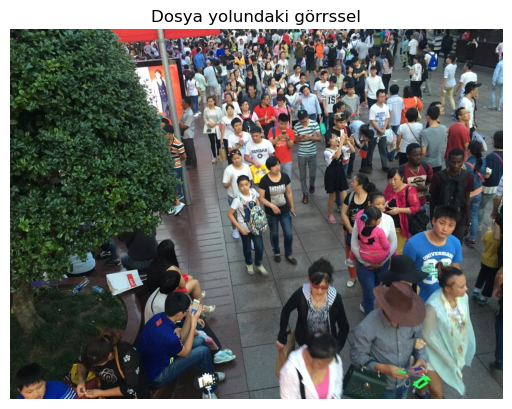

In [23]:
import cv2

image_path = ""
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis('off')
plt.title("Dosya yolundaki görrssel")
plt.show()

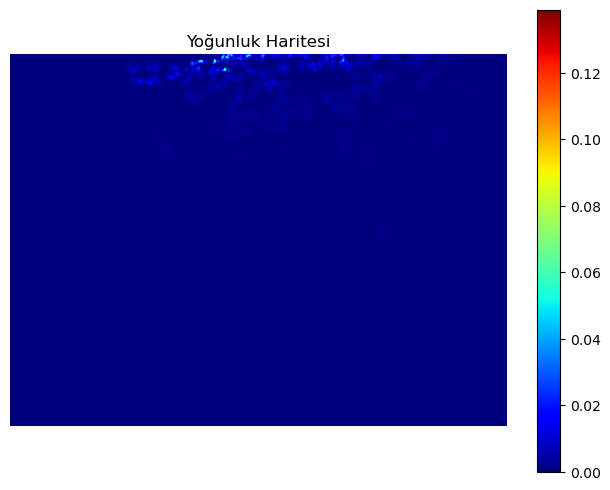

In [24]:
h5_path = ''
with h5py.File(h5_path, 'r') as gt_file:
    density = np.asarray(gt_file['density'])


plt.figure(figsize=(8, 6))
plt.imshow(density, cmap=CM.jet)
plt.title("Yoğunluk Haritesi")
plt.axis('off')  #
plt.colorbar()
plt.show()

### Önemsiz Kısım

In [ ]:
"""
def ımport_all_data(image_dir, gt_dir, label="", image_size=(512, 512), sigma=15):
    data = []

    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    gt_paths = sorted(glob(os.path.join(gt_dir, "*.mat")))

    for image_path, gt_path in zip(image_paths, gt_paths):
        image = cv2.imread(image_path)  # BGR formatında okunur
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB'ye çevir
        orginal_shape = image.shape[:2]
        resized_image = cv2.resize(image, image_size)
        resized_image = resized_image.astype('float32') / 255.0

        head_points = loadmat(gt_path)['image_info'][0][0][0][0][0]
        orginal_h, orginal_w = orginal_shape
        new_h, new_w = image_size

        resized_points = [(int(x * new_w / orginal_w), int(y * new_h / orginal_h)) for (x,y) in head_points]

        # Density map oluştur
        density_map = generate_density_map(image_size, resized_points, sigma=sigma)

        unique_filename = f"{label}_{os.path.basename(image_path)}"
        data.append({
            "filename": unique_filename,
            "image": torch.tensor(resized_image).permute(2, 0, 1),  # (3, H, W) tensor formatı
            "count": len(head_points),
            "coordinates": resized_points,
            "density_map": density_map
        })
    return pd.DataFrame(data)
"""